# 14.1 Multilevel Regression

To demonstrate multilevel regression models, we use a the `sleepstudy` dataset from `statsmodels`. This is a well-known dataset in the field of mixed-effects modeling often used to illustrate the effects of sleep deprivation on cognitive performance. It contains measurements from a study on reaction times of 18 participants under sleep deprivation conditions over a period of 10 days and contains the following variables:

- `Reaction` - the reaction time in milliseconds, which serves as the outcome variable
- `Days` - the number of days the participant has been sleep-deprived, ranging from 0 to 9
- `Subject` - A unique identifier for each participant, allowing for random effects in the model

In [1]:
# Load packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = sm.datasets.get_rdataset("sleepstudy", "lme4").data
print(data.head())

   Reaction  Days  Subject
0  249.5600     0      308
1  258.7047     1      308
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308


## Plot the data

First, we plot a regression line through all data points, ignoring the nesting of individual subjects observations:

$$\hat{Reaction Time}_i = \beta_0 + \beta_1 * Days of deprivation_i + \epsilon_i$$

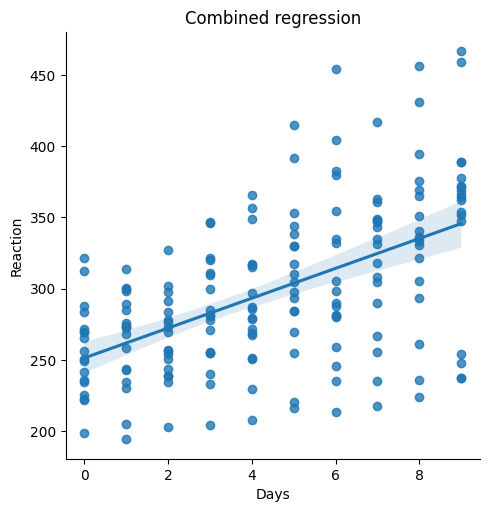

In [2]:
sns.lmplot(x='Days', y='Reaction', data=data)
plt.title("Combined regression");

Next, let's plot one for each subject, using `Subject` as the hue:

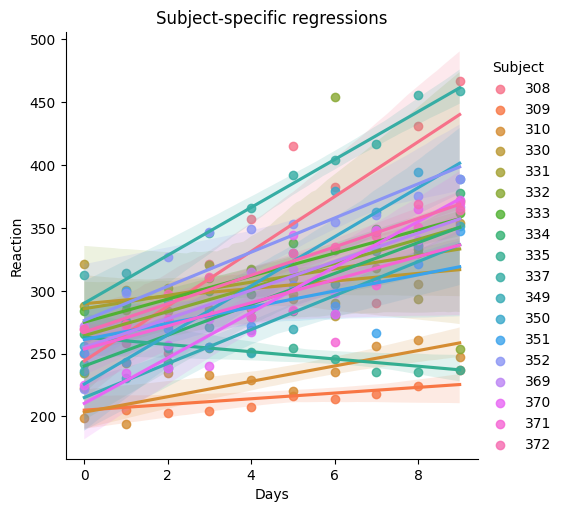

In [3]:
sns.lmplot(x='Days', y='Reaction', hue='Subject', data=data)
plt.title("Subject-specific regressions");

## Reading the plot
By **nesting** participants observations, and plotting a regression line for each participant we recover **patterns of variability** that would have otherwise been be lost (or averaged out). Instead of treating each data point as independend observation, we coorectly **group the dependent observations**(nesting) with one an other, grouping by subject, and look at the variation across participants. 
  
**Intercept Variability**:
  The intercept represents the baseline `Reaction` time for each subject when `Days` = 0.
  Some subjects have naturally higher baseline `Reaction` times, while others have lower ones. This variability suggests that individuals start at different points in terms of their `Reaction` times.

**Slope Variability**:
  The slope represents the relationship between `Days` and `Reaction` time for each subject. It indicates how reaction times change as the number of days of sleep deprivation increases. Some subjects show a strong positive relationship (steep slope), meaning their `Reaction` times increase noticeably over `Days`. Others show little to no relationship.

## Fitting multilevel regression models

In the following, we will create three multilevel regression models to provide an answer to the following research questions:

- **Q1:** How much of the variation in `Reaction` is due to differences between `Subjects`?  

  - **Model 1: The unconditional model** - 
      This model includes no predictors and serves as a baseline to estimate how much of the variance in `Reaction` is attributable to differences between `Subjects` (i.e., partitioning within-subject and between-subject variability).


- **Q2:** What is the average effect of `Days` on `Reaction` across all `Subjects`?

  - **Model 2: The random intercept model** - 
      This model includes Days as a predictor at the within-subject level (Level 1). It assumes that all `Subjects` have the same slope (i.e., the effect of `Days` on `Reaction` is constant across individuals), but allows each `Subject` to have their own baseline level of `Reaction` (*random intercept*).


- **Q3 and Q4:** Does the effect of `Days` on `Reaction` vary across `Subject`? Is there a relationship between an individual baseline reaction time (`Reaction` at `Days = 0`) and their rate of change in `Reaction` over time (i.e., is there a correlation between intercept and slope)?

  -  **Model 3: The random intercept and random slope model** - 
      This model extends **Model 2** by allowing both intercepts and slopes to vary across `Subjects`. It tests whether individual `Subjects` differ in how their `Reaction` changes over time (*random slopes*) and whether there is a correlation between an individual starting `Reaction` level and their rate of change.

### Model 1 - The unconditional model

**Q1**: How much of the variation in `Reaction` is due to differences between `Subjects`?

There is no predictor in the unconditional model. Here, we only estimate the intercept of `Reaction` and let it vary across the Level-2 units (`Subject`). The proportion of variance attributed to Level-1 units and Level-2 units can be estimated based on the estimated parameters in this model. In other words, this model can be used to compute the **Intra-Class Correlation (ICC)** coefficient, which indicates the strength of the effect of `Subject` (Level-2) on `Reaction`. More on **ICC** in the next sections.

In [4]:
# define and fit the unconditional model
model1 = smf.mixedlm("Reaction ~ 1",
                     data=data,
                     groups=data["Subject"])

# fit the model using the BFGS optimization method
model1_fit = model1.fit(method="bfgs")

# print the summary of the model
print(model1_fit.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Reaction 
No. Observations:  180     Method:             REML     
No. Groups:        18      Scale:              1958.8670
Min. group size:   10      Log-Likelihood:     -952.1633
Max. group size:   10      Converged:          Yes      
Mean group size:   10.0                                 
--------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  298.508    9.050 32.985 0.000 280.770 316.245
Group Var 1278.324   12.009                             



The summary provides two coefficients:

- `Intercept`: The intercept (298.508) represents the estimated average reaction time at Day 0 (baseline level of `Reaction`) across all subjects. As indicated by the p-value, the intercept is significantly different from zero (p = 0.000). This is the *fixed effect*.
- `Group Var`: The variance of the random intercept is 1278.324. This value indicates how much individual subjects vary in their average reaction times at baseline. This is the *random effect*.

#### Intraclass Correlation Coefficient (ICC)
There is no included function to get the ICC. However, we can quickly code it ourselves:

```{admonition} Intraclass Correlation Coefficient (ICC)
:class: tip 

The ICC represents the proportion of the total variation in the outcome that can be explained by differences between groups, rather than differences within groups:

$$ 
\text{ICC} = \frac{\sigma^2_{\text{between}}}{\sigma^2_{\text{between}} + \sigma^2_{\text{within}}}
$$ 
```

In [5]:
# create function to calculate ICC
def calculate_icc(results):
    icc = results.cov_re / (results.cov_re + results.scale)
    return round(icc.values[0, 0], 4)

# call the function with your fitted model to calculate ICC
calculate_icc(model1_fit)

0.3949

An ICC of 0.39 indicates that 39% of the variance in `Reaction` is due to inter-individual differences.

### Model 2 - The random intercept model

**Q2**: What is the average effect of `Days` on `Reaction` across all `Subjects`?

We now add the variable `Days` as predictor for `Reaction`. By estimating the average (fixed) slope, this model will inform about the average relationship between `Days` and `Reaction`. In this model, there is a predictor `Days` at Level-1 (individual), random intercepts and constant slopes across Level-2 units (`Subject`).

In [6]:
# define and fit the random intercept model
# this model includes "days" as a predictor at level 1
model2 = smf.mixedlm("Reaction ~ Days",
                     data=data,
                     groups=data["Subject"])

# fit the model using the BFGS optimization method
model2_fit = model2.fit(method="bfgs")

# print summary 
print(model2_fit.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Reaction 
No. Observations:  180     Method:             REML     
No. Groups:        18      Scale:              960.4568 
Min. group size:   10      Log-Likelihood:     -893.2325
Max. group size:   10      Converged:          Yes      
Mean group size:   10.0                                 
--------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  251.405    9.747 25.794 0.000 232.302 270.508
Days        10.467    0.804 13.015 0.000   8.891  12.044
Group Var 1378.176   17.156                             



The summary provides three coefficients:

- `Intercept`: The intercept (251.405) represents the estimated average reaction time at baseline (days = 0), across all subjects. This is significantly different from zero (p = 0.000).
- `Days`: The average relationship (slope) between `Days` and `Reaction`. This indicates that, on average, for each additional day, 
the reaction time increases by approximately 10.47 ms. This is significantly different from zero (p = 0.000).
- `Group Var`: The variance of the random intercept is 1378.232. This value indicates how much individual subjects vary in their average reaction times at baseline. A higher variance suggests greater variability among subjects’ intercepts, meaning individual differences play a significant role in determining baseline reaction times.

### Model 3 - The random intercept and random slope model

**Q3**: Does the effect of `Days` on `Reaction` vary across `Subject`?

**Q4**: Is there a relationship between an individual baseline reaction time (`Reaction` at `Days = 0`) and their rate of change in `Reaction` over time (i.e., is there a correlation between intercept and slope)?

Model 3 includes the `Days` predictor (level 1), a random intercept, and a random slope. This model estimates the variance of the slope and determines whether the relationship between `Days` and `Reaction` varies across individuals (`Subject`). We now additionally provide `re_formula` as a one-sided random effects formula defining the variance structure of the model. This specifies that random effects are modeled as a function of `Days`, allowing each subject to have its own intercept and slope.

In [7]:
# define the random intercept and random slope model
# model includes "days" as a predictor at level 1 
model3 = smf.mixedlm("Reaction ~ Days",    
                     data=data,
                     groups=data["Subject"],
                     re_formula="~Days")        #random effects

# fit the model
model3_fit = model3.fit(method="bfgs")

# print summary
print(model3_fit.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Reaction 
No. Observations:    180       Method:               REML     
No. Groups:          18        Scale:                654.9405 
Min. group size:     10        Log-Likelihood:       -871.8141
Max. group size:     10        Converged:            Yes      
Mean group size:     10.0                                     
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        251.405    6.825 36.838 0.000 238.029 264.781
Days              10.467    1.546  6.771 0.000   7.438  13.497
Group Var        612.096   11.881                             
Group x Days Cov   9.605    1.821                             
Days Var          35.072    0.610                             



We now get additional coefficients (`Group x Days Cov` and `Days Var`):

- `Days Var`: Represents the variance of the random slopes for the `Days` variable across `Subject`. Some subjects have a steeper increase in reaction time over days, while others may have a slower or negligible increase. A high variance thus indicates more variability among individuals in how their reaction times change over days. 
- `Group x Days Cov`: Describes the covariance between the random intercept and the random slope for `Days`. The positive covariance indicates that subjects with higher baseline reaction times (intercepts) also tend to have larger increases in reaction time over days (steeper slopes).